# Colegio de Postgraduados Campus Montecillo 

### Posgrado en Socioeconomía, Estadística e Informática

### <b>Cómputo Aplicado</b>

Entrenamiento para clasificación de enfermedades en frutos de aguacate utilizando el Algoritmo de <i>Random Forest</i>.

<b>Paso 1</b>: Importar las librerías necesarias. 

In [14]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

<b>Paso 2</b>: Definir la ruta de trabajo. 

In [15]:
ruta = "/Users/campos/Documents/COA 690/Entrenamientos Jupyter/Conjunto de datos/"
os.chdir(ruta)

<b>Paso 3</b>: Leer el conjunto de datos 

In [16]:
datos = pd.read_csv("Idento 30.csv")
datos.head()

,img_name,H,S,V,R,G,B,y
0,Avocado 31.jpg,32,191,174,167,174,44,0
1,Avocado 31.jpg,25,194,168,168,147,40,0
2,Avocado 31.jpg,23,198,169,169,140,38,0
3,Avocado 31.jpg,32,191,176,169,176,44,0
4,Avocado 31.jpg,26,200,170,170,153,37,0


Tomando la columna <i>y</i>; las clases quedan de la siguiente forma: 0 para frutos sanos, 1 para frutos con roña y 2 para frutos con antracnosis. 

<b>Paso 4</b>: Extraer las observaciones y sus etiquetas.

In [17]:
X = datos.iloc[:, 1:4].values
X_s = X.shape
y = datos.iloc[:, 7].values
y_s = y.shape

print("El total de las observaciones para las tripletas HSV son :", X_s)
print("El total de las etiquetas para cada observación son: ", y_s[0])

El total de las observaciones para las tripletas HSV son : (45536, 3)
El total de las etiquetas para cada observación son:  45536


Se probará la partición <b>80:20</b>; es decir, que el $80 \%$ de los datos serán utilizados para el entrenamiento y validación; y el $20 \%$ restante será para la prueba del modelo.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y)

<b>Paso 5</b>: Se llama al modelo de <i>Random Forest</i>, donde se utilizarán los hiperparámetros por defecto.

In [19]:
rfc = RandomForestClassifier(random_state = 1)

<b>Paso 6</b>: Optimización de mejores hiperparámetros.

Se le conoce como búsqueda por retícula, o <i>grid search</i>, al método que consiste en definir intervalos de hiperparámetros, y el modelo realizará todas las combinaciones posibles para determinar los mejores que se ajusten y entreguen la precisión global (PG) más alta.

In [12]:
estimator_range = [100, 200, 300, 1000]
max_depth_range = [4, 6, 8]

In [13]:
param_grid = [{'n_estimators': estimator_range,
               'max_features': [ 'sqrt'],
               'max_depth': max_depth_range,
               'criterion': ['gini', 'entropy']}]

In [14]:
gs = GridSearchCV(estimator = rfc,
                  param_grid = param_grid,
                  scoring = 'accuracy',
                  cv = 10,
                  n_jobs = -1,
                  refit = True)

Validación cruzada

Este consiste en subdividir el conjunto de entrenamiento en grupos definidos por el usuario ($k$), en donde un subgrupo servirá como una muestra de validación para que el modelo optimice los hiperparámetros. Este es un proceso iterativo, donde cada $k$ pasará a ser un subgrupo de validación que se evaluará con los restantes.

In [15]:
kfold = StratifiedKFold(n_splits = 10).split(X_train, y_train)
scores = []
for k, (train, test) in enumerate(kfold):
    rfc.fit(X_train[train], y_train[train])
    score = rfc.score(X_train[test], y_train[test])
    scores.append(score)
    print("Partición: %2d, Class dist.: %s, Acc: %.5f" % (k+1, np.bincount(
        y_train[train]), score))

Partición:  1, Class dist.: [10953 10682 11150], Acc: 0.96788
Partición:  2, Class dist.: [10953 10682 11150], Acc: 0.96816
Partición:  3, Class dist.: [10953 10682 11150], Acc: 0.96843
Partición:  4, Class dist.: [10953 10682 11150], Acc: 0.96322
Partición:  5, Class dist.: [10953 10682 11150], Acc: 0.97035
Partición:  6, Class dist.: [10953 10682 11150], Acc: 0.96679
Partición:  7, Class dist.: [10953 10682 11150], Acc: 0.96459
Partición:  8, Class dist.: [10953 10682 11150], Acc: 0.96953
Partición:  9, Class dist.: [10953 10683 11150], Acc: 0.97090
Partición: 10, Class dist.: [10953 10682 11151], Acc: 0.97364


Para este caso, estos valores pertenecen al modelo RF con los hiperparámetros por defecto, a continuación se obtendrán los mejores hiperparámetros. 

In [16]:
gs = gs.fit(X_train, y_train)
gs.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'sqrt',
 'n_estimators': 1000}

<b>Paso 7</b>: Con base a esos mejores hiperparámetros, se realiza un nuevo entrenamiento, donde se definen esos valores en el modelo. 

In [20]:
pipe_rfc = make_pipeline(StandardScaler(),
                         RandomForestClassifier(criterion = 'gini',
                                                max_depth = 8,
                                                max_features = 'sqrt',
                                                n_estimators = 1000,
                                                random_state = 1))

In [21]:
kfold = StratifiedKFold(n_splits = 10).split(X_train, y_train)
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_rfc.fit(X_train[train], y_train[train])
    score = pipe_rfc.score(X_train[test], y_train[test])
    scores.append(score)
    print("Partición: %2d, Class dist.: %s, Acc: %.5f" % (k+1, np.bincount(
        y_train[train]), score))

Partición:  1, Class dist.: [10953 10682 11150], Acc: 0.96075
Partición:  2, Class dist.: [10953 10682 11150], Acc: 0.96816
Partición:  3, Class dist.: [10953 10682 11150], Acc: 0.96651
Partición:  4, Class dist.: [10953 10682 11150], Acc: 0.96596
Partición:  5, Class dist.: [10953 10682 11150], Acc: 0.96871
Partición:  6, Class dist.: [10953 10682 11150], Acc: 0.96596
Partición:  7, Class dist.: [10953 10682 11150], Acc: 0.96184
Partición:  8, Class dist.: [10953 10682 11150], Acc: 0.96706
Partición:  9, Class dist.: [10953 10683 11150], Acc: 0.96815
Partición: 10, Class dist.: [10953 10682 11151], Acc: 0.97254


In [22]:
pipe_rfc.score(X_train, y_train)

0.9695838366092017

<b>Paso 7</b>: Evaluar el modelo con los datos de prueba ($20 \%$) 

In [23]:
y_train_pred = pipe_rfc.predict(X_train)
y_test_pred = pipe_rfc.predict(X_test)
y_proba = pipe_rfc.predict_proba(X_test) # Este es utilizado para crear las curvas ROC - AUC

<b>Paso 8</b>: Obtener matriz de confusión y curvas ROC - AUC para los datos de prueba 

In [22]:
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      3043
           1       0.99      0.95      0.97      2967
           2       0.97      0.98      0.97      3098

    accuracy                           0.97      9108
   macro avg       0.97      0.97      0.97      9108
weighted avg       0.97      0.97      0.97      9108



Como se puede observar, la matriz de confusión redondea al entero siguiente los valores de exactitud o <i>accuracy</i>. 

<b>Matriz de confusión</b>

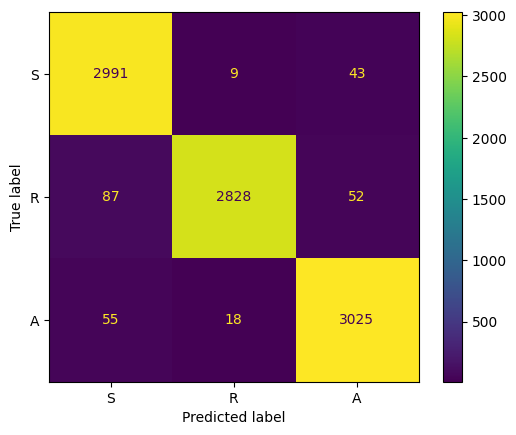

In [23]:
etiquetas = ["S", "R", "A"]
cm = confusion_matrix(y_test, y_test_pred, labels = pipe_rfc.classes_)
display = ConfusionMatrixDisplay(confusion_matrix = cm,
                                 display_labels = etiquetas)
display.plot()

Donde S corresponde a los frutos sanos; R a los frutos con roña y A a los frutos con antracnosis. 

<b>Curva ROC y AUC</b> 

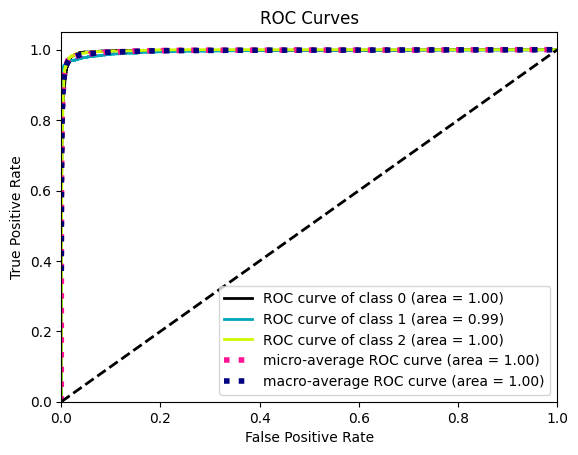

In [24]:
skplt.metrics.plot_roc(y_test, y_proba)
plt.show()

Adicionalmente, se realizó otro entrenamiento, que, para este caso, se utilizó el $100 \%$ de los datos para entrenamiento y validación, utilizando los hiperparámetros optimizados. 

In [24]:
kfold = StratifiedKFold(n_splits = 10).split(X, y)
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_rfc.fit(X[train], y[train])
    score = pipe_rfc.score(X[test], y[test])
    scores.append(score)
    print("Partición: %2d, Class dist.: %s, Acc: %.5f" % (k+1, np.bincount(
        y[train]), score))

Partición:  1, Class dist.: [13691 13353 13938], Acc: 0.95982
Partición:  2, Class dist.: [13691 13353 13938], Acc: 0.92358
Partición:  3, Class dist.: [13691 13353 13938], Acc: 0.97826
Partición:  4, Class dist.: [13692 13352 13938], Acc: 0.96640
Partición:  5, Class dist.: [13692 13352 13938], Acc: 0.97628
Partición:  6, Class dist.: [13692 13352 13938], Acc: 0.92688
Partición:  7, Class dist.: [13692 13352 13939], Acc: 0.96640
Partición:  8, Class dist.: [13692 13352 13939], Acc: 0.97540
Partición:  9, Class dist.: [13692 13352 13939], Acc: 0.89458
Partición: 10, Class dist.: [13692 13353 13938], Acc: 0.86185


In [25]:
pipe_rfc.score(X, y)

0.9634574841883345

In [26]:
y_test_pred = pipe_rfc.predict(X)
y_proba = pipe_rfc.predict_proba(X) # Este es utilizado para crear las curvas ROC - AUC

In [27]:
print(metrics.classification_report(y, y_test_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96     15213
           1       0.99      0.94      0.97     14836
           2       0.95      0.98      0.97     15487

    accuracy                           0.96     45536
   macro avg       0.96      0.96      0.96     45536
weighted avg       0.96      0.96      0.96     45536



<b>Como se puede observar, utilizando la partición 80:20, se obtuvo una precisión más alta que con el conjunto de los datos totales (97 vs 96)</b>. 

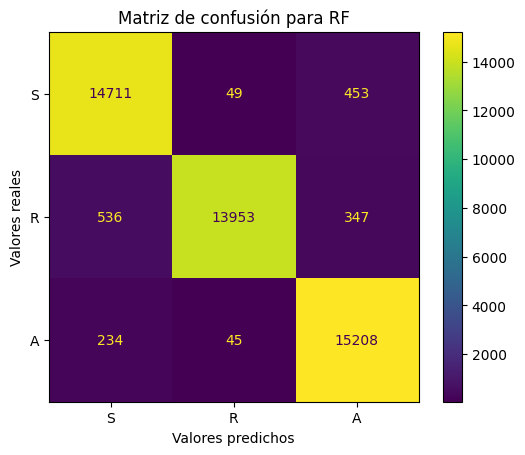

In [28]:
etiquetas = ["S", "R", "A"]
cm = confusion_matrix(y, y_test_pred, labels = pipe_rfc.classes_)
display = ConfusionMatrixDisplay(confusion_matrix = cm,
                                 display_labels = etiquetas)
display.plot()
plt.title("Matriz de confusión para RF")
plt.xlabel("Valores predichos")
plt.ylabel("Valores reales")
plt.show()

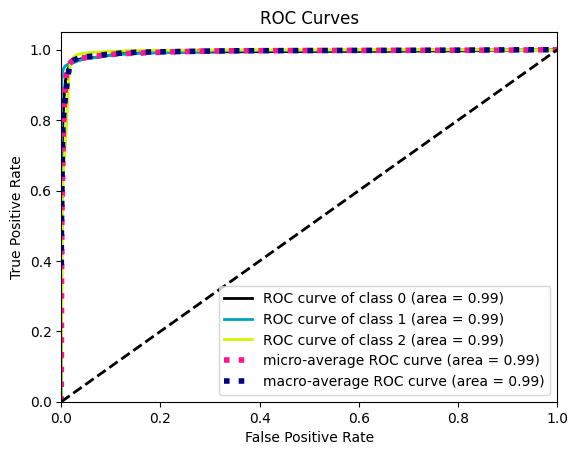

In [13]:
skplt.metrics.plot_roc(y, y_proba)
plt.show()

Existe una ligera diferencia entre las curvas, para ambos conjuntos de datos. 